## Задача 9. Титаник

Импорт модулей

In [224]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Получение данных

In [225]:
train = pd.read_csv("train.csv", index_col="PassengerId")

train.rename(columns={"Pclass": "Class"}, inplace=True)
train["Class"] = train["Class"].astype("category")
train["Class"] = train["Class"].cat.rename_categories({1: "1st", 2: "2nd", 3: "3rd"})
train["Sex"] = train["Sex"].astype("category")
train["Sex"] = train["Sex"].cat.rename_categories({"female": "Female", "male": "Male"})
train["Embarked"] = train["Embarked"].astype("category")
train["Embarked"] = train["Embarked"].cat.rename_categories({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
train[:10]

,Survived,Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3rd,"Braund, Mr. Owen Harris",Male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton
2,1,1st,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Female,38.0,1,0,PC 17599,71.2833,C85,Cherbourg
3,1,3rd,"Heikkinen, Miss. Laina",Female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton
4,1,1st,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Female,35.0,1,0,113803,53.1000,C123,Southampton
5,0,3rd,"Allen, Mr. William Henry",Male,35.0,0,0,373450,8.0500,NaN,Southampton
6,0,3rd,"Moran, Mr. James",Male,NaN,0,0,330877,8.4583,NaN,Queenstown
7,0,1st,"McCarthy, Mr. Timothy J",Male,54.0,0,0,17463,51.8625,E46,Southampton
8,0,3rd,"Palsson, Master. Gosta Leonard",Male,2.0,3,1,349909,21.0750,NaN,Southampton
9,1,3rd,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Female,27.0,0,2,347742,11.1333,NaN,Southampton


# Первичный анализ

In [226]:
train.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [227]:
train.isnull().sum()

,0
Survived,0
Class,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [228]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Class     891 non-null    category
 2   Name      891 non-null    object  
 3   Sex       891 non-null    category
 4   Age       714 non-null    float64 
 5   SibSp     891 non-null    int64   
 6   Parch     891 non-null    int64   
 7   Ticket    891 non-null    object  
 8   Fare      891 non-null    float64 
 9   Cabin     204 non-null    object  
 10  Embarked  889 non-null    category
dtypes: category(3), float64(2), int64(3), object(3)
memory usage: 65.6+ KB


# Замена Nan значений

Для Embarked заменим NaN на самое распространенное значение

In [229]:
train.groupby("Embarked")["Name"].count()

<ipython-input-229-e64a90d6fa7d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby("Embarked")["Name"].count()


,Name
Embarked,
Cherbourg,168
Queenstown,77
Southampton,644


Southampton встречается чаще всего

Разбиваем по фамилиям, чтобы определить коэффициент выживаемости для семьи.

Заполняем NaN значения в Age медианой и разбиваем на возрастные группы.

Заменяем NaN в Embarked на Southampton.

Разбиваем Fare на 4 равные группы.

In [230]:
train['LastName'] = train['Name'].transform(lambda x: x.split(',')[0])
family_survival = train.groupby('LastName')['Survived'].transform('mean')
train['FamilySurvivalRate'] = family_survival.fillna(0)

train["Age"] = train.groupby(["Class"])["Age"].transform(lambda x: x.fillna(x.median()))
train['AgeClass'] = pd.cut(train['Age'], bins=[0, 14, 25, 50, 80], labels=['kid', 'young', 'Adult', 'elderly'])


train = train.fillna({"Embarked" : "Southampton"})
train['FareBand'] = pd.qcut(train['Fare'], 4, labels=["low", "mid", "high", "very high"])

train[:10]

<ipython-input-230-e8e8dea2ba48>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train["Age"] = train.groupby(["Class"])["Age"].transform(lambda x: x.fillna(x.median()))


,Survived,Class,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LastName,FamilySurvivalRate,AgeClass,FareBand
PassengerId,,,,,,,,,,,,,,,
1,0,3rd,"Braund, Mr. Owen Harris",Male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Braund,0.000000,young,low
2,1,1st,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Female,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,Cumings,1.000000,Adult,very high
3,1,3rd,"Heikkinen, Miss. Laina",Female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Heikkinen,1.000000,Adult,mid
4,1,1st,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Female,35.0,1,0,113803,53.1000,C123,Southampton,Futrelle,0.500000,Adult,very high
5,0,3rd,"Allen, Mr. William Henry",Male,35.0,0,0,373450,8.0500,NaN,Southampton,Allen,0.500000,Adult,mid
6,0,3rd,"Moran, Mr. James",Male,24.0,0,0,330877,8.4583,NaN,Queenstown,Moran,0.333333,young,mid
7,0,1st,"McCarthy, Mr. Timothy J",Male,54.0,0,0,17463,51.8625,E46,Southampton,McCarthy,0.000000,elderly,very high
8,0,3rd,"Palsson, Master. Gosta Leonard",Male,2.0,3,1,349909,21.0750,NaN,Southampton,Palsson,0.000000,kid,high
9,1,3rd,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Female,27.0,0,2,347742,11.1333,NaN,Southampton,Johnson,0.500000,Adult,mid


# Визуализация

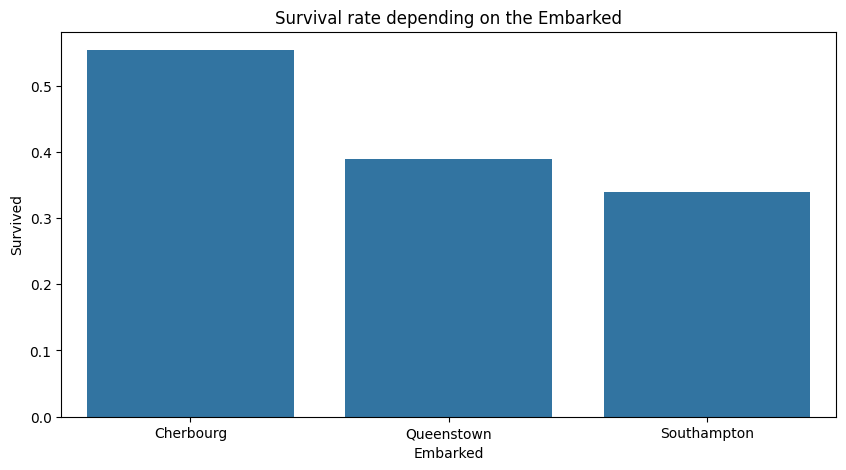

In [231]:
plt.figure(figsize=(10,5))
sns.barplot(data=train, x='Embarked', y='Survived', errorbar=None)
plt.title("Survival rate depending on the Embarked")
plt.xlabel("Embarked")
plt.ylabel("Survived")
plt.show()

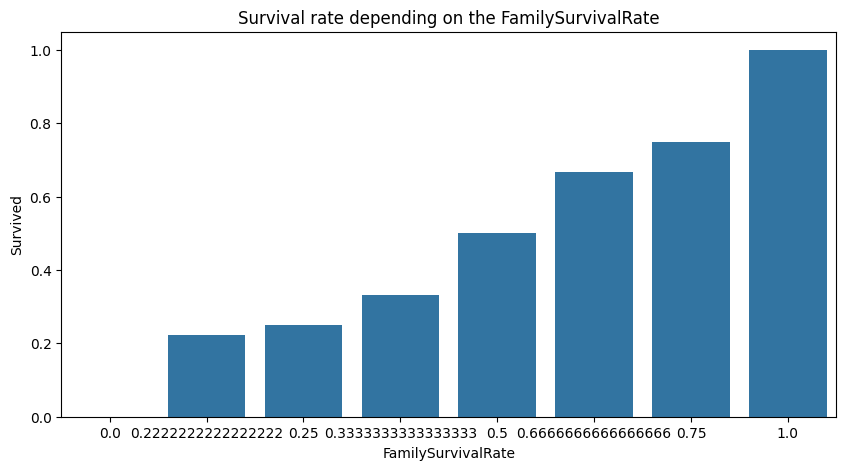

In [232]:
plt.figure(figsize=(10,5))
sns.barplot(data=train, x='FamilySurvivalRate', y='Survived', errorbar=None)
plt.title("Survival rate depending on the FamilySurvivalRate")
plt.xlabel("FamilySurvivalRate")
plt.ylabel("Survived")
plt.show()

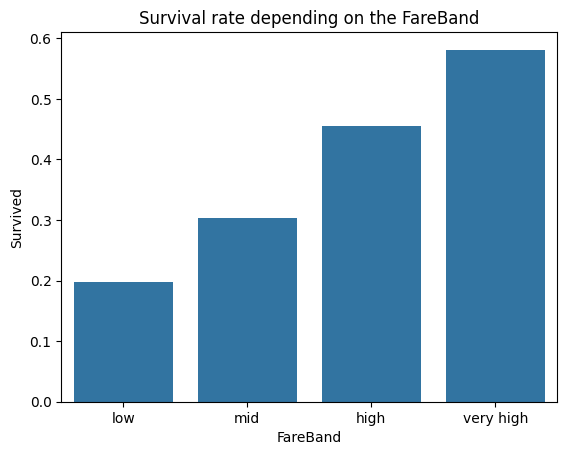

In [233]:
sns.barplot(data=train, x='FareBand', y='Survived', errorbar=None)
plt.title("Survival rate depending on the FareBand")
plt.xlabel("FareBand")
plt.ylabel("Survived")
plt.show()

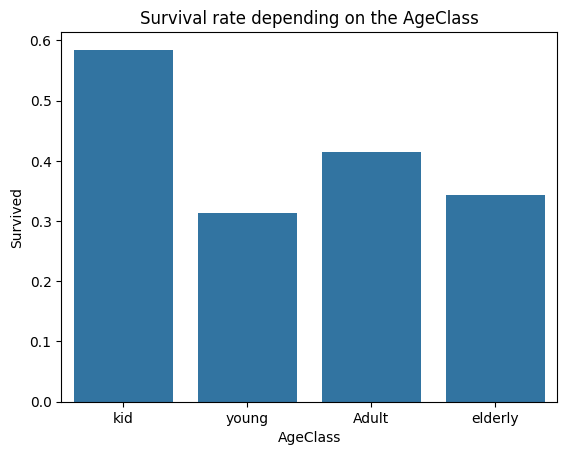

In [234]:
sns.barplot(data=train, x='AgeClass', y='Survived', errorbar=None)
plt.title("Survival rate depending on the AgeClass")
plt.xlabel("AgeClass")
plt.ylabel("Survived")
plt.show()

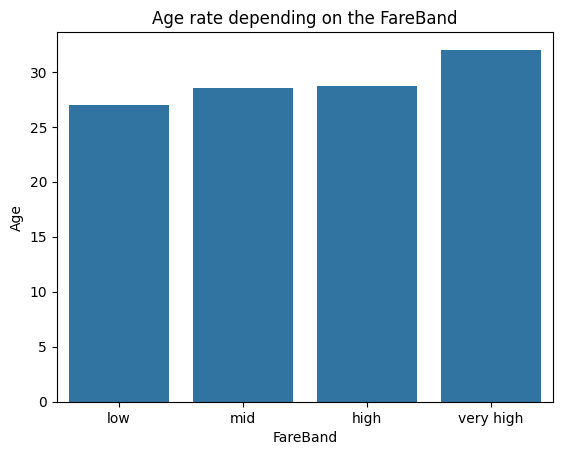

In [235]:
sns.barplot(data=train, x='FareBand', y='Age', errorbar=None)
plt.title("Age rate depending on the FareBand")
plt.xlabel("FareBand")
plt.ylabel("Age")
plt.show()

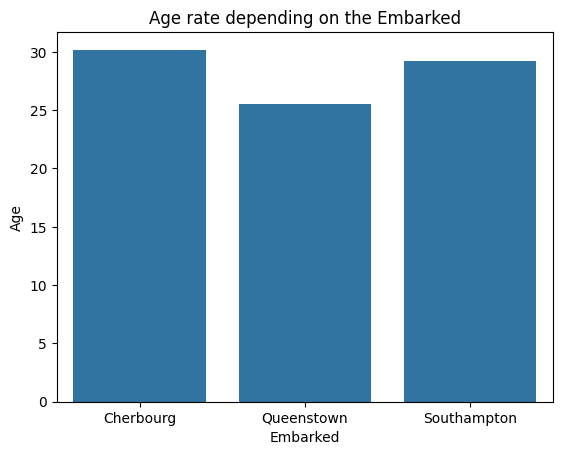

In [236]:
sns.barplot(data=train, x='Embarked', y='Age', errorbar=None)
plt.title("Age rate depending on the Embarked")
plt.xlabel("Embarked")
plt.ylabel("Age")
plt.show()

Удаляем столбцы которые не влияют (либо влияют незначительно) на обучение модели

In [237]:
X = train.drop(["Ticket", "Cabin", "Survived", "Name", "SibSp", "Parch", "LastName"], axis=1)
X

,Class,Sex,Age,Fare,Embarked,FamilySurvivalRate,AgeClass,FareBand
PassengerId,,,,,,,,
1,3rd,Male,22.0,7.2500,Southampton,0.000000,young,low
2,1st,Female,38.0,71.2833,Cherbourg,1.000000,Adult,very high
3,3rd,Female,26.0,7.9250,Southampton,1.000000,Adult,mid
4,1st,Female,35.0,53.1000,Southampton,0.500000,Adult,very high
5,3rd,Male,35.0,8.0500,Southampton,0.500000,Adult,mid
...,...,...,...,...,...,...,...,...
887,2nd,Male,27.0,13.0000,Southampton,0.000000,Adult,mid
888,1st,Female,19.0,30.0000,Southampton,0.666667,young,high
889,3rd,Female,24.0,23.4500,Southampton,0.000000,young,high


In [238]:
Y = train["Survived"]

Представляем данные в необходимом для обучения виде

In [239]:
AgeGroup = pd.get_dummies(X['AgeClass'], drop_first=True)
FareBand = pd.get_dummies(X['FareBand'], drop_first=True)
Sex = pd.get_dummies(X['Sex'], drop_first=True)
Embark = pd.get_dummies(X['Embarked'], drop_first=True)
Class = pd.get_dummies(X['Class'], drop_first=True)

X.drop(['Sex', 'Embarked', 'Class', 'FareBand', 'AgeClass'], axis=1, inplace=True)

X = pd.concat([X, Sex, Embark, Class, AgeGroup, FareBand], axis=1)
X

,Age,Fare,FamilySurvivalRate,Male,Queenstown,Southampton,2nd,3rd,young,Adult,elderly,mid,high,very high
PassengerId,,,,,,,,,,,,,,
1,22.0,7.2500,0.000000,True,False,True,False,True,True,False,False,False,False,False
2,38.0,71.2833,1.000000,False,False,False,False,False,False,True,False,False,False,True
3,26.0,7.9250,1.000000,False,False,True,False,True,False,True,False,True,False,False
4,35.0,53.1000,0.500000,False,False,True,False,False,False,True,False,False,False,True
5,35.0,8.0500,0.500000,True,False,True,False,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,27.0,13.0000,0.000000,True,False,True,True,False,False,True,False,True,False,False
888,19.0,30.0000,0.666667,False,False,True,False,False,True,False,False,False,True,False
889,24.0,23.4500,0.000000,False,False,True,False,True,True,False,False,False,True,False


# Классификация

Разбиваем данные. Соотношение тренировочных и тестовых соответсвенно 0.8 и 0.2.

In [240]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Для классификации используем модель `SGDClassifier` с перебором наилучших параметров с помощью `GridSearchCV`.



In [241]:
from sklearn.tree import DecisionTreeClassifier

# create dict with paramemeters for model
param_grid_clf = {
    'max_depth': [3, 5, 10, 15, None],
}

# create model
clf = DecisionTreeClassifier(random_state=42)

# selection of best parameters
grid_search_clf = GridSearchCV(clf, param_grid_clf, cv=5, n_jobs=-1, scoring='f1')

# train model
grid_search_clf.fit(X_train, Y_train)

# check of best parameters
print("best parameters for SGDClassifier:", grid_search_clf.best_params_)

# prediction of results
y_pred = grid_search_clf.predict(X_test)

# check of metric values
print(classification_report(Y_test, y_pred))
print("accuracy_score:", accuracy_score(Y_test, y_pred))

best parameters for SGDClassifier: {'max_depth': 10}
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       105
           1       0.97      0.96      0.97        74

    accuracy                           0.97       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.97      0.97      0.97       179

accuracy_score: 0.9720670391061452


  - `precision` для выживших --- 0.97 > 0.79
  - `recall` для выживших --- 0.96 > 0.72
  - `f1_score` для выживших --- 0.97 > 0.75
  - `accuracy` --- 0.97 > 0.8
  - `precision` для погибших --- 0.97 > 0.81
  - `recall` для погибших --- 0.98 > 0.88

Вывод:

Создание новых признаков увеличило точность модели.

In [242]:
from sklearn.linear_model import SGDClassifier

# create dict with paramemeters for model
param_grid_clf = {
    'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_error'],
    'max_iter': [100, 200, 400, 800, 1000]
}

# create model
clf = SGDClassifier(random_state=42)

# selection of best parameters
grid_search_clf = GridSearchCV(clf, param_grid_clf, cv=5, n_jobs=-1, scoring='f1')

# train model
grid_search_clf.fit(X_train, Y_train)

# check of best parameters
print("best parameters for SGDClassifier:", grid_search_clf.best_params_)

# prediction of results
y_pred = grid_search_clf.predict(X_test)

# check of metric values
print(classification_report(Y_test, y_pred))
print("accuracy_score:", accuracy_score(Y_test, y_pred))

best parameters for SGDClassifier: {'loss': 'modified_huber', 'max_iter': 100}
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       105
           1       0.91      0.97      0.94        74

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

accuracy_score: 0.9497206703910615


  - `precision` для выживших --- 0.91 > 0.79
  - `recall` для выживших --- 0.97 > 0.72
  - `f1_score` для выживших --- 0.94 > 0.75
  - `accuracy` --- 0.95 > 0.8
  - `precision` для погибших --- 0.98 > 0.81
  - `recall` для погибших --- 0.93 > 0.88

Вывод:

На имеющихся данных другие модели так же могут достаточно точно предсказывать результаты.

# Линейная регрессия

Удаляем столбец Age.

In [243]:
Y = X['Age']
X = X.drop(['Age'], axis=1)
X

,Fare,FamilySurvivalRate,Male,Queenstown,Southampton,2nd,3rd,young,Adult,elderly,mid,high,very high
PassengerId,,,,,,,,,,,,,
1,7.2500,0.000000,True,False,True,False,True,True,False,False,False,False,False
2,71.2833,1.000000,False,False,False,False,False,False,True,False,False,False,True
3,7.9250,1.000000,False,False,True,False,True,False,True,False,True,False,False
4,53.1000,0.500000,False,False,True,False,False,False,True,False,False,False,True
5,8.0500,0.500000,True,False,True,False,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,13.0000,0.000000,True,False,True,True,False,False,True,False,True,False,False
888,30.0000,0.666667,False,False,True,False,False,True,False,False,False,True,False
889,23.4500,0.000000,False,False,True,False,True,True,False,False,False,True,False


In [244]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [245]:
model = LinearRegression().fit(X_train, Y_train)

In [246]:
Y_pred = model.predict(X_test)

In [247]:
print(np.sqrt(mean_squared_error(Y_test, Y_pred)))

4.976231693844215


  - `RootMeanSquaredError` для возраста пассажиров --- 4.98 < 10.7

Вывод:

Новые признаки повысили точность модели для предсказания возраста пассажиров.

# Вывод по работе

Эмпирическим путем, работой над данными, грамотным подбором гиперпараметров, были выбраны и обучены модели.

Достаточно высокие значения метрик свидетельствуют об успешном решении задачи.